In [1]:
import requests
import sys
import pandas as pd
import numpy as np
from scipy import sparse
from io import StringIO
import networkscience as ns
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
reply = requests.get('https://data.europa.eu/euodp/data/storage/f/2020-08-11T140550/Finalised%20mobilities%20started%20in%202018%20-%20KA1.csv')
reply.encoding = 'utf-8'

In [3]:
csv_data = reply.text
df = pd.read_csv(StringIO(csv_data), sep=';',low_memory=False, header=0)
for i, name in enumerate(df.columns):
    print(i, name)

0 Project Reference
1 Academic Year
2 Mobility Start Month
3 Mobility End Month
4 Mobility Duration
5 Activity (mob)
6 Field of Education
7 Participant Nationality
8 Education Level
9 Participant Gender
10 Participant Profile
11 Special Needs
12 Fewer Opportunities
13 Participant Age
14 Sending Country Code
15 Sending City
16 Sending Organization
17 Receiving Country Code
18 Receiving City
19 Receiving Organization
20 Participants


In [4]:
pd.options.display.max_columns=21
display(df)

,Project Reference,Academic Year,Mobility Start Month,Mobility End Month,Mobility Duration,Activity (mob),Field of Education,Participant Nationality,Education Level,Participant Gender,Participant Profile,Special Needs,Fewer Opportunities,Participant Age,Sending Country Code,Sending City,Sending Organization,Receiving Country Code,Receiving City,Receiving Organization,Participants
0,2015-3-PT02-KA105-002866,2017-18,2018-01,2018-05,146,European Voluntary Service - Programme Countries,???,PT,??? - ???,Male,Learner,No,No,22,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
1,2015-3-PT02-KA105-002866,2017-18,2018-01,2018-05,146,European Voluntary Service - Programme Countries,???,PT,??? - ???,Male,Learner,No,Yes,26,PT,VISEU,ADAMASTOR - ASSOCIACAO CULTURAL,PL,Poznań,Stowarzyszenie Jeden Swiat,1
2,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,Staff,No,No,27,AT,Wien,Neue Mittelschule Glasergasse,SI,Portoro�,Osnovna sola Lucija,1
3,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,Staff,No,No,28,AT,Vienna,NMSI & JHS Konstanziagasse 50,SI,Portoro�,Osnovna sola Lucija,1
4,2016-1-AT01-KA101-016290,2017-18,2018-01,2018-01,6,Structured Courses/Training Events,Teacher training without subject specialization,AT,??? - ???,Female,Staff,No,No,35,AT,Wien,GTKMS/GTNMS Anton-Sattler-Gasse,SI,Portoro�,Osnovna sola Lucija,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688505,2018-2-UK01-KA125-048625,2018-19,2018-09,2019-07,319,Individual Volunteering Activities,???,ES,??? - ???,Female,Learner,No,No,21,ES,Madrid,Asociación para la integración y Progreso de l...,UK,Stackpole,The National Trust for Places of Historic Inte...,1
688506,2018-2-UK01-KA125-048626,2018-19,2018-10,2019-03,137,Individual Volunteering Activities,???,ES,??? - ???,Male,Learner,No,No,27,ES,BARCELONA,COORDINADORA D'ORGANITZADORS DE CAMPS DE TREBA...,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
688507,2018-2-UK01-KA125-048626,2018-19,2018-11,2019-04,170,Individual Volunteering Activities,???,CZ,??? - ???,Female,Learner,No,No,24,CZ,PRAHA,INEX - SDRUZENI DOBROVOLNYCH AKTIVIT Z S,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1
688508,2018-2-UK01-KA125-048626,2018-19,2018-11,2019-10,351,Individual Volunteering Activities,???,FR,??? - ???,Male,Learner,No,No,23,FR,PARIS,SOLIDARITES JEUNESSES MCP,UK,LONDON,VOLUNTEER ACTION FOR PEACE,1


In [5]:
mobility_df = df[df[df.columns[10]]=='Learner']
mobility_df = mobility_df[mobility_df['Activity (mob)'].str.contains('Student')]
mobility_df = mobility_df[~mobility_df['Activity (mob)'].str.contains('traineeship')]
# consideriamo solo l'anno accademico 2018/2019 o 2017/2018?
# i numeri cambiano parecchio di anno in anno, è normale?
#mobility_df = mobility_df[mobility_df['Academic Year'].str.contains('19')]
mobility_df = mobility_df.loc[:, df.columns[np.array((16, 19, 20, 5))]]
print((mobility_df['Receiving Organization'].nunique()))
print((mobility_df['Sending Organization'].nunique()))

3759
4264


In [6]:
for index in range(len(mobility_df['Sending Organization'])):
    s_uni = mobility_df.iat[index,0]
    r_uni = mobility_df.iat[index,1]
    if s_uni != s_uni.upper():
        mobility_df.iat[index,0] = s_uni.upper()
    if r_uni != r_uni.upper():
        mobility_df.iat[index,1] = r_uni.upper()

print('Number of Receiving Universities: ',(mobility_df['Receiving Organization'].nunique()))
print('Number of Sending Universities: ',(mobility_df['Sending Organization'].nunique()))
mobility_df


Number of Receiving Universities:  3668
Number of Sending Universities:  4189


,Sending Organization,Receiving Organization,Participants,Activity (mob)
174,VORARLBERGER LANDESKONSERVATORIUM,LUNDS UNIVERSITET,1,Student mobility for studies between Programme...
195,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...
196,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...
197,NATIONAL MINING UNIVERSITY,MONTANUNIVERSITAT LEOBEN,1,Student mobility for Studies To/From Partner C...
198,MONTANUNIVERSITAT LEOBEN,THE NATIONAL MINERAL RESOURCES UNIVERSITY (THE...,1,Student mobility for Studies To/From Partner C...
...,...,...,...,...
667190,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Student mobility for Studies To/From Partner C...
667191,UNIVERSITY COLLEGE LONDON,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,1,Student mobility for Studies To/From Partner C...
667192,FEDERAL STATE AUTONOMOUS EDUCATIONAL INSTITUTI...,UNIVERSITY COLLEGE LONDON,1,Student mobility for Studies To/From Partner C...
667193,UNIVERSITY COLLEGE LONDON,THE HEBREW UNIVERSITY OF JERUSALEM,1,Student mobility for Studies To/From Partner C...


In [7]:
nodes = np.array(list(set.union(set(mobility_df.loc[:, mobility_df.columns[0]]), set(mobility_df.loc[:, mobility_df.columns[1]]))))
node_position = {}
for i, name in enumerate(nodes):
    node_position[name] = i
nodes_df = pd.DataFrame({'Nodes': nodes})
mobility_df['SendId'] = (np.array(list(map(lambda x: node_position[x], mobility_df['Sending Organization']))))
mobility_df['RecId']= (np.array(list(map(lambda x: node_position[x], mobility_df['Receiving Organization']))))
# Adjacency matrix
adj_matrix_crs = sparse.csr_matrix((nodes.size, nodes.size),dtype=int)
adj_matrix_csc = sparse.csc_matrix((nodes.size, nodes.size),dtype=int)

In [8]:
mobility_serie = mobility_df.groupby(['SendId', 'RecId']).sum()
row = np.array(mobility_serie.index.get_level_values(1).tolist())
col = np.array(mobility_serie.index.get_level_values(0).tolist())
val = mobility_serie.values
adj_matrix_crs = sparse.csr_matrix((val.flatten(), (row, col)), shape=(nodes.size, nodes.size))

# cercasi 70 Gb di ram, no perditempo
# ns.visualize_adj(adj_matrix_crs)

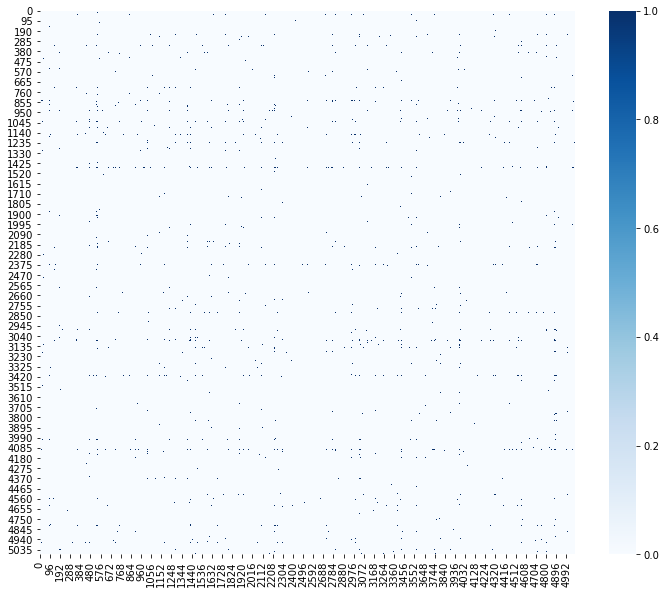

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
a_adj = adj_matrix_crs.toarray()
a_adj[a_adj>1] = 1
sns.heatmap(a_adj, cmap="Blues", ax=ax)
plt.show()

In [10]:
mobility_df.rename({'Sending Organization': 'source','Receiving Organization': 'target', 'Participants':'weight'},axis=1, inplace=True)
adj_matrix_crs, mobility_df, nodes_df = ns.keep_giant(ns.find_components(adj_matrix_crs, nodes_df), mobility_df)

### Degree distribution

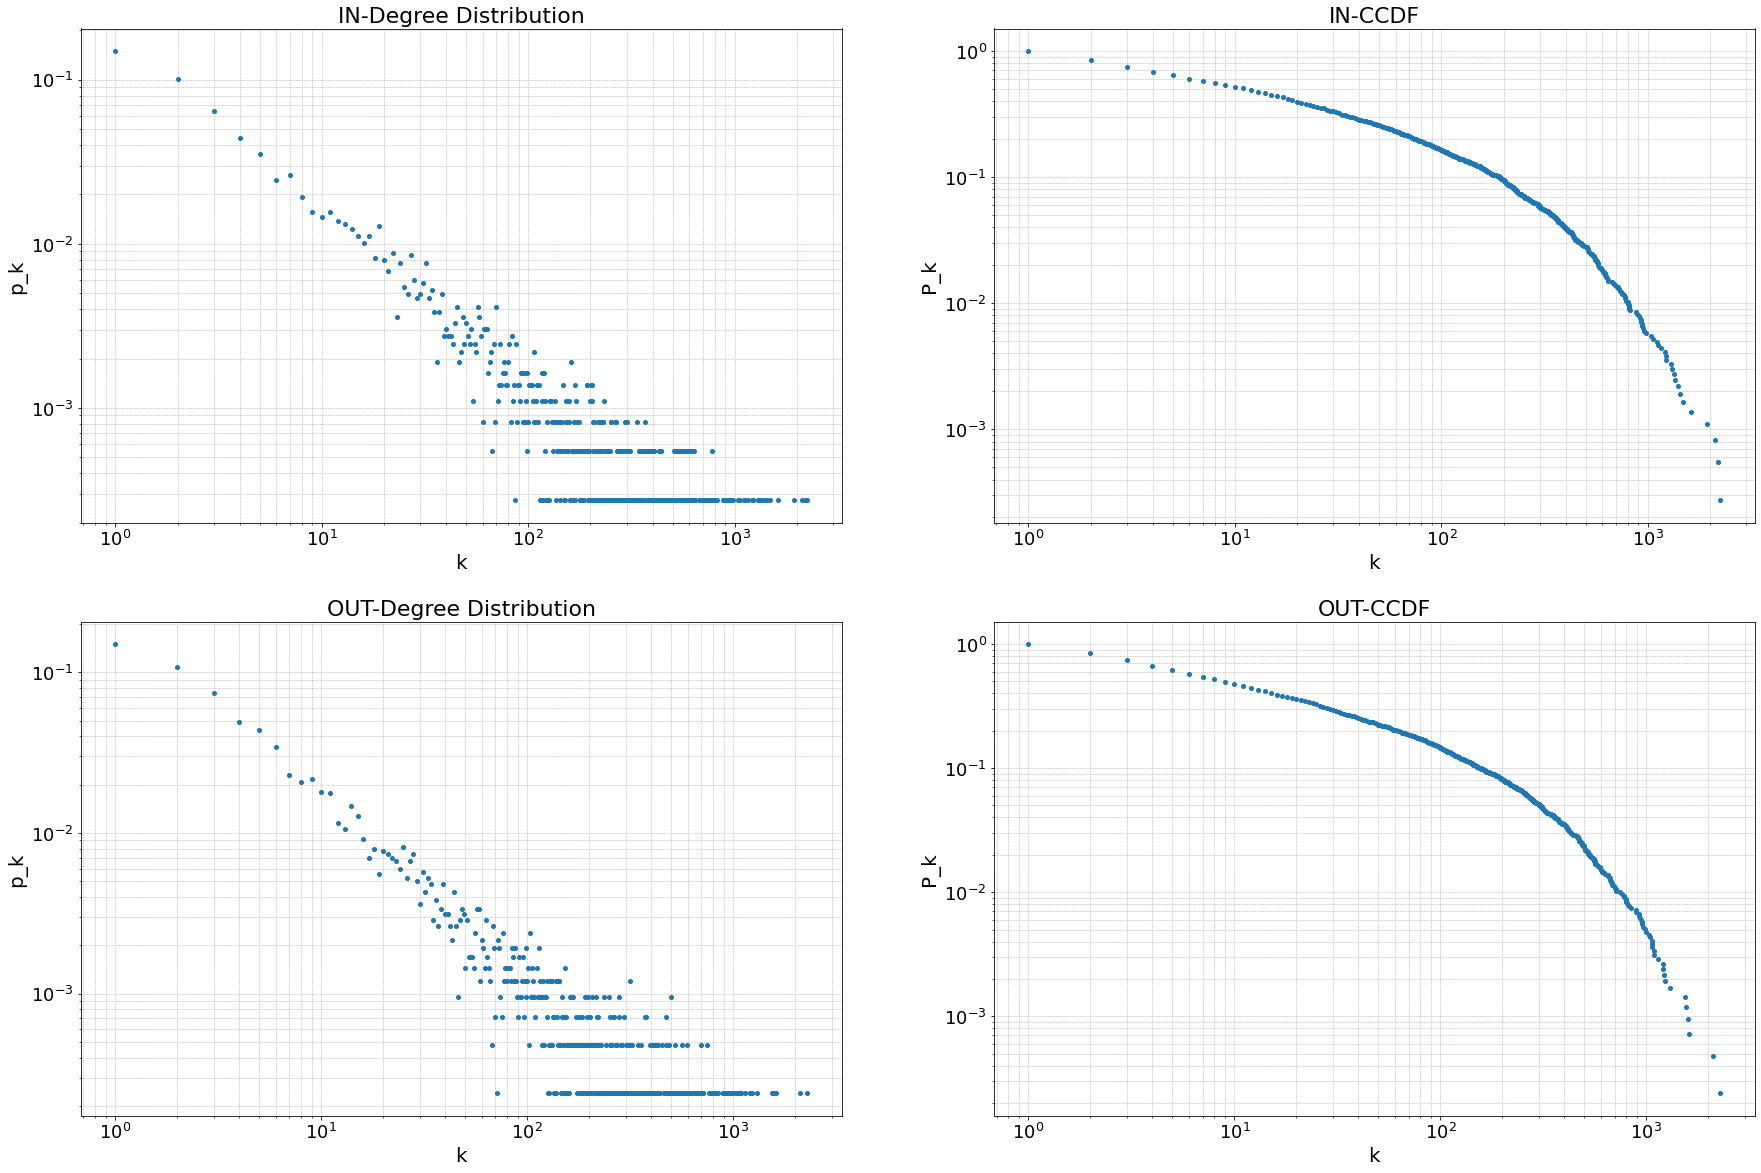

Top 10 for in degree


,Nodes,in degree
548,UNIVERSITAT DE VALENCIA,2239
4590,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2181
2416,UNIVERSIDADE DE LISBOA,2118
266,UNIVERSIDAD DE GRANADA,1934
111,UNIVERSIDAD COMPLUTENSE DE MADRID,1615
4340,UNIVERZA V LJUBLJANI,1483
3049,UNIVERSITAT POLITECNICA DE VALENCIA,1436
3425,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,1406
1890,UNIVERSIDAD DE SEVILLA,1352
4078,KATHOLIEKE UNIVERSITEIT LEUVEN,1340


Top 10 for out degree


,Nodes,out degree
4590,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,2280
266,UNIVERSIDAD DE GRANADA,2114
548,UNIVERSITAT DE VALENCIA,1604
111,UNIVERSIDAD COMPLUTENSE DE MADRID,1590
1457,UNIVERSITA DEGLI STUDI DI PADOVA,1563
2193,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,1544
1272,UNIVERSITA DEGLI STUDI DI TORINO,1299
2416,UNIVERSIDADE DE LISBOA,1230
4078,KATHOLIEKE UNIVERSITEIT LEUVEN,1218
836,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,1206


In [11]:
scores = ns.degree_disribution(adj_matrix_crs, nodes_df, print_graph=True)
ns.display_top_n(scores, 10, 'in degree')
ns.display_top_n(scores, 10, 'out degree')

### Estimating $\gamma$ 

In [12]:
from collections import Counter
from statistics import mean

d_in = scores['in degree']
d_in = d_in[d_in>0]
d_out = scores['out degree']
d_out = d_out[d_out>0]
kmin = 100
d2_in = d_in[d_in>kmin]
d2_out = d_out[d_out>kmin]

sorted_d = sorted(d_in)
occurrence = Counter(sorted_d)
x_in = list(occurrence.keys())
y_in = list(occurrence.values())
y_in = y_in/np.sum(y_in)

sorted_d = sorted(d_out)
occurrence = Counter(sorted_d)
x_out = list(occurrence.keys())
y_out = list(occurrence.values())
y_out = y_out/np.sum(y_out)

Pk_in = 1 - np.cumsum(y_in)
Pk_in[-1] = 1 
Pk_in = sorted(Pk_in, reverse = True)
Pk_out = 1 - np.cumsum(y_out)
Pk_out[-1] = 1 
Pk_out = sorted(Pk_out, reverse = True)

In [13]:
ga_in = 1 + 1/mean(np.array(np.log(d2_in/kmin)))
ga_out = 1 + 1/mean(np.array(np.log(d2_out/kmin)))
C_in = (ga_in-1)*kmin**(ga_in-1) # normalization condition
C_out = (ga_out-1)*kmin**(ga_out-1)

pos_in = np.argmax(np.array(x_in)>=kmin)
pos_out = np.argmax(np.array(x_out)>=kmin)

P_kmin_in = Pk_in[pos_in] # constant value that shifts the line where the data are placed
pk_in = C_in*P_kmin_in*x_in**-ga_in
Pk_est_in = C_in*P_kmin_in*x_in**(-(ga_in-1))/(ga_in-1) 

P_kmin_out = Pk_out[pos_out] # constant value that shifts the line where the data are placed
pk_out = C_out*P_kmin_out*x_out**-ga_out
Pk_est_out = C_out*P_kmin_out*x_out**(-(ga_out-1))/(ga_out-1) 

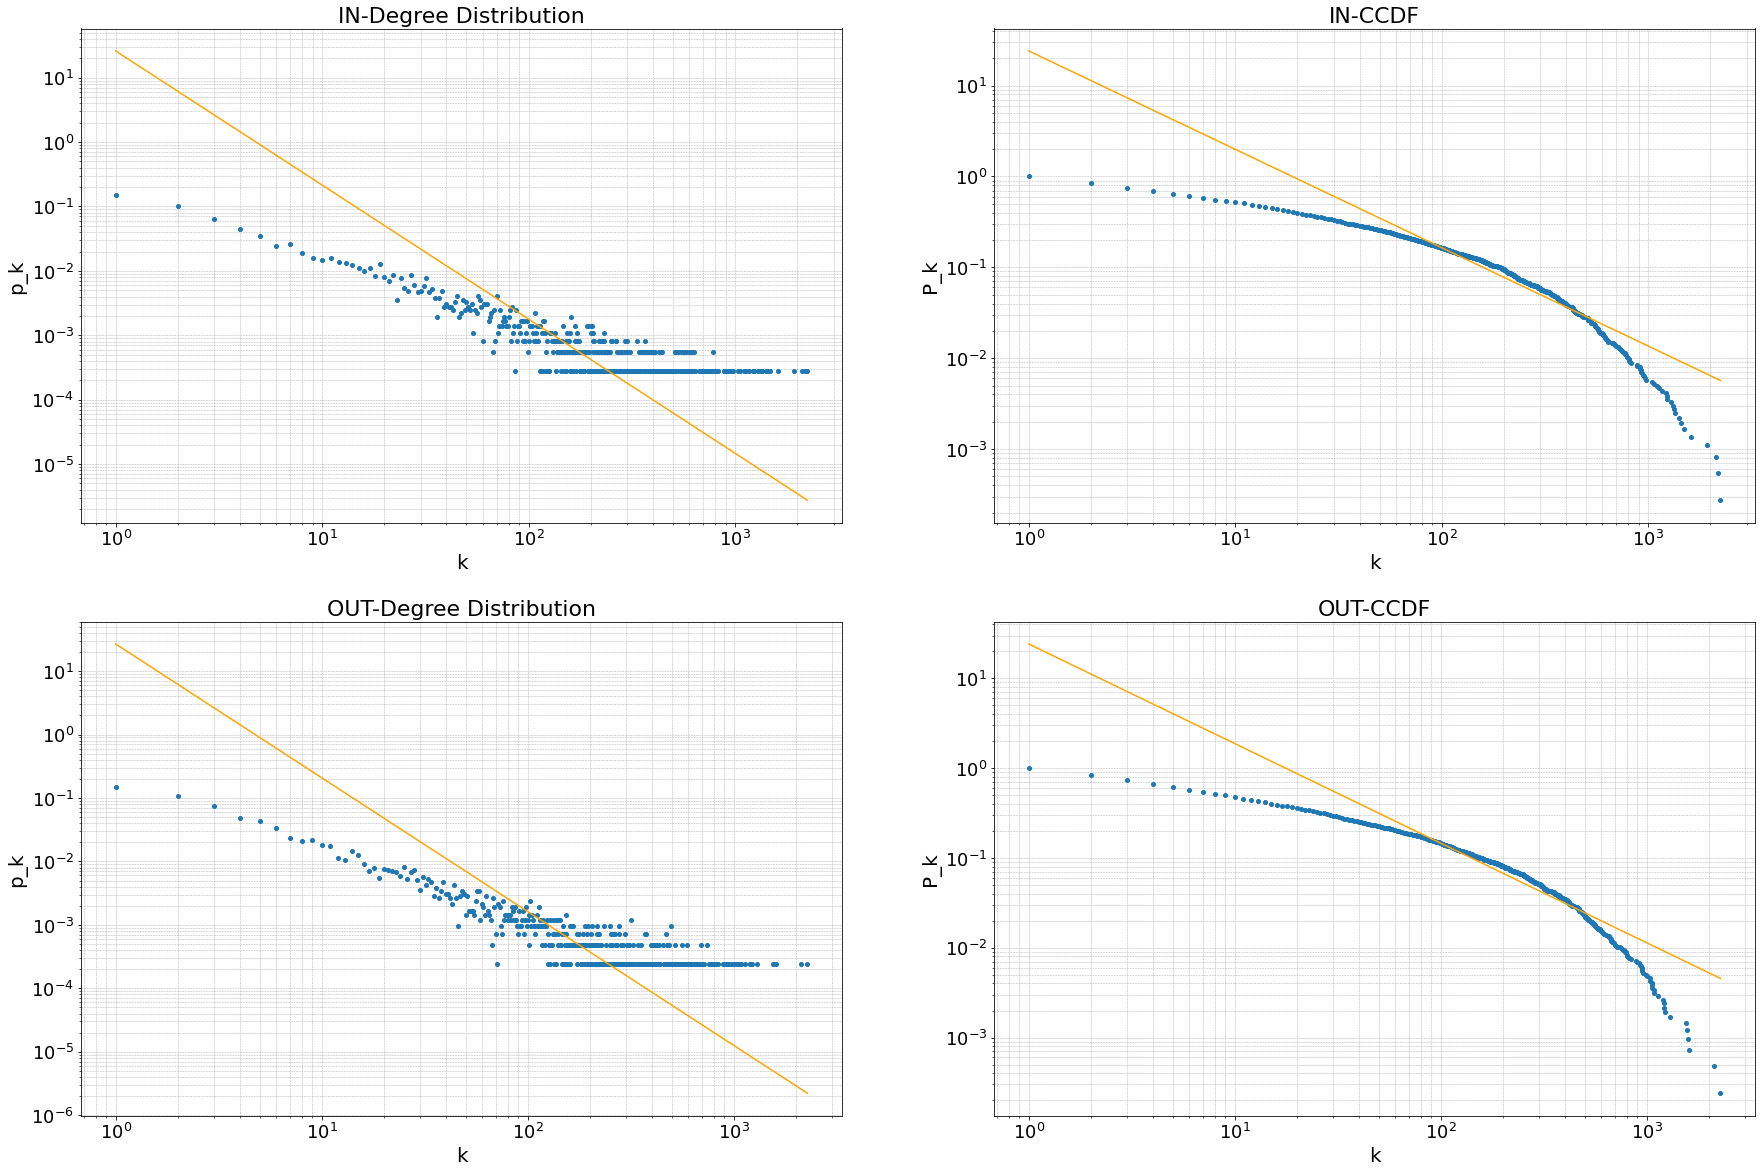

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (30, 20))

def plot_gamma(ax, x, y, title, p, cumulative=False):
    ax.loglog(x, y, 'o', markersize = 4)
    ax.loglog(x, p, color='orange')
    ax.grid(which='both', linestyle='--', linewidth=0.5)
    ax.set_title(title, size = 22)
    ax.set_xlabel("k", size = 20)
    if cumulative:
        ax.set_ylabel("P_k", size = 20)
    else:
        ax.set_ylabel("p_k", size = 20)
    ax.tick_params(labelsize=18)
    ax.tick_params(labelsize=18)

plot_gamma(ax[0,0], x_in, y_in, "IN-Degree Distribution", pk_in)
plot_gamma(ax[0,1], x_in, Pk_in, "IN-CCDF", Pk_est_in, True)
plot_gamma(ax[1,0], x_out, y_out, "OUT-Degree Distribution", pk_out)
plot_gamma(ax[1,1], x_out, Pk_out, "OUT-CCDF", Pk_est_out, True)
plt.show()

### Estimating $\gamma$ through a linear fit with log binning

In [15]:
# Log binning 
nbins = 20
bins = np.logspace(0, 3.3, nbins)

hist_in = np.histogram(d_in, bins=bins, density=True)
hist_out = np.histogram(d_out, bins=bins, density=True)
logbin_p_k_in = hist_in[0]
logbin_p_k_out = hist_out[0]
middle_bins = np.sqrt( np.delete(bins, 0) * np.delete(bins, nbins-1) )

mask = np.log10(middle_bins) > np.log10(kmin)
x = np.log10( middle_bins[mask] )
y_in = np.log10( logbin_p_k_in[mask] )
y_out = np.log10( logbin_p_k_out[mask] )

# Linear fit
params_in = np.polyfit(x, y_in, deg =1)
params_out = np.polyfit(x, y_out, deg =1)
lin_gamma_in = -params_in[0]
lin_gamma_out = -params_out[0]

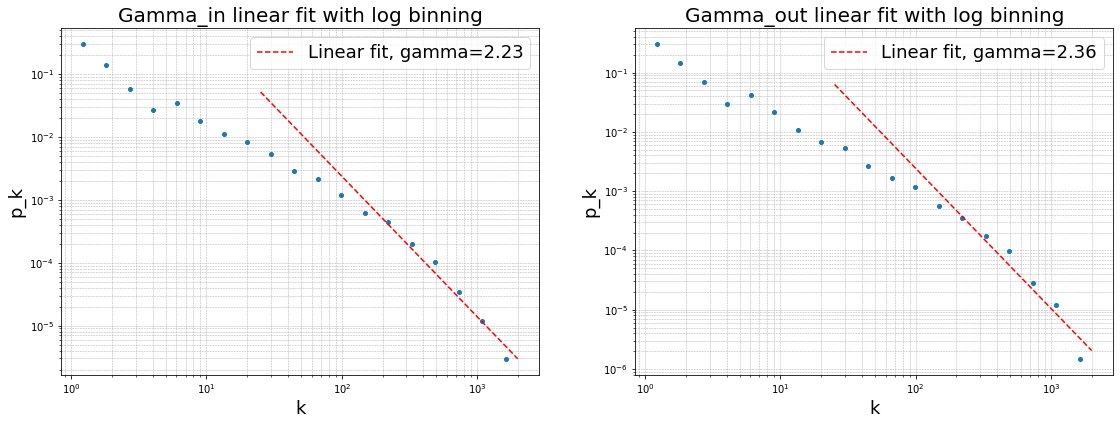

In [16]:
plt.figure(figsize=(60, 60))
plt.subplot(8, 6, 1)
plt.loglog(middle_bins, logbin_p_k_in , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_in linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_in[1])*x2**(-lin_gamma_in) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_in,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.subplot(8, 6, 2)
plt.loglog(middle_bins, logbin_p_k_out , 'o', markersize = 4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title("Gamma_out linear fit with log binning", size = 20)
plt.xlabel("k", size = 18)
plt.ylabel("p_k", size = 18)
x2 = np.logspace(1.4,3.3,100)
y2 = np.full( 100, 10**(params_out[1])*x2**(-lin_gamma_out) ) 
plt.plot(x2,y2, label ="Linear fit, gamma="+str( np.round(lin_gamma_out,2) ), color="red", linestyle="--")
plt.legend(fontsize=18)

plt.show()

### HITS (NetworkX)

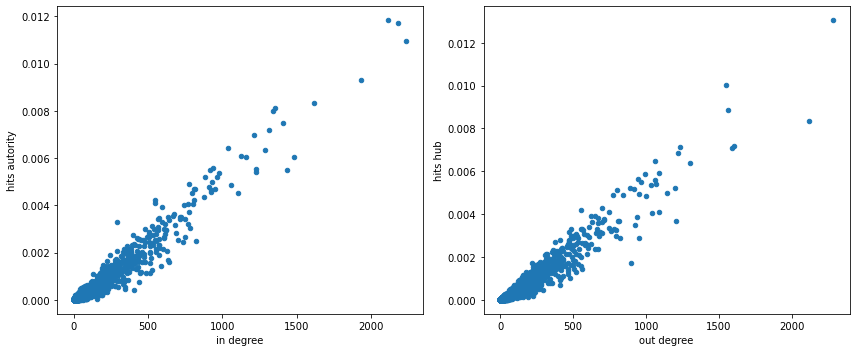

Top 10 for hits hub


,Nodes,hits hub
2868,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.013047
3517,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.010031
2006,UNIVERSITA DEGLI STUDI DI PADOVA,0.008866
4141,UNIVERSIDAD DE GRANADA,0.008332
4581,UNIVERSITAT DE VALENCIA,0.007194
804,UNIVERSIDADE DE LISBOA,0.007115
2961,UNIVERSIDAD COMPLUTENSE DE MADRID,0.007101
287,KATHOLIEKE UNIVERSITEIT LEUVEN,0.006870
198,TECHNISCHE UNIVERSITAET MUENCHEN,0.006476
3506,UNIVERSITA DEGLI STUDI DI TORINO,0.006369


Top 10 for hits autority


,Nodes,hits autority
804,UNIVERSIDADE DE LISBOA,0.011827
2868,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.011717
4581,UNIVERSITAT DE VALENCIA,0.010963
4141,UNIVERSIDAD DE GRANADA,0.009295
2961,UNIVERSIDAD COMPLUTENSE DE MADRID,0.008322
1460,UNIVERSIDAD DE SEVILLA,0.008102
287,KATHOLIEKE UNIVERSITEIT LEUVEN,0.007990
2523,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.007498
1936,UNIVERZITA KARLOVA,0.007183
3880,UNIVERSITAT DE BARCELONA,0.006963


In [17]:
df = ns.hits_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'hits hub')
ns.display_top_n(scores, 10, 'hits autority')

### PageRank (NetworkX)

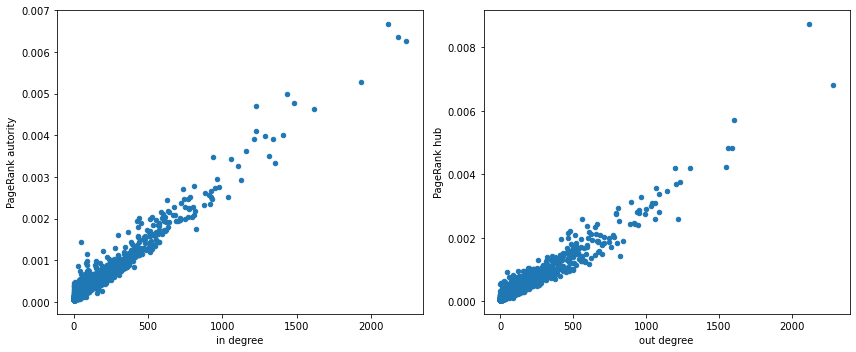

Top 10 for PageRank hub


,Nodes,PageRank hub
4141,UNIVERSIDAD DE GRANADA,0.008724
2868,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006795
4581,UNIVERSITAT DE VALENCIA,0.005713
2961,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004827
2006,UNIVERSITA DEGLI STUDI DI PADOVA,0.004826
3517,UNIVERSITA DEGLI STUDI DI ROMA LA SAPIENZA,0.004223
114,UNIVERSIDAD POLITECNICA DE MADRID,0.004187
3506,UNIVERSITA DEGLI STUDI DI TORINO,0.004185
804,UNIVERSIDADE DE LISBOA,0.003746
1899,UNIVERSIDAD DEL PAIS VASCO/ EUSKAL HERRIKO UNI...,0.003685


Top 10 for PageRank autority


,Nodes,PageRank autority
804,UNIVERSIDADE DE LISBOA,0.006671
2868,ALMA MATER STUDIORUM - UNIVERSITA DI BOLOGNA,0.006371
4581,UNIVERSITAT DE VALENCIA,0.006263
4141,UNIVERSIDAD DE GRANADA,0.005291
3004,UNIVERSITAT POLITECNICA DE VALENCIA,0.004997
4300,UNIVERZA V LJUBLJANI,0.004764
66,POLITECNICO DI MILANO,0.004715
2961,UNIVERSIDAD COMPLUTENSE DE MADRID,0.004639
2006,UNIVERSITA DEGLI STUDI DI PADOVA,0.004098
2523,NORGES TEKNISK-NATURVITENSKAPELIGE UNIVERSITET...,0.004001


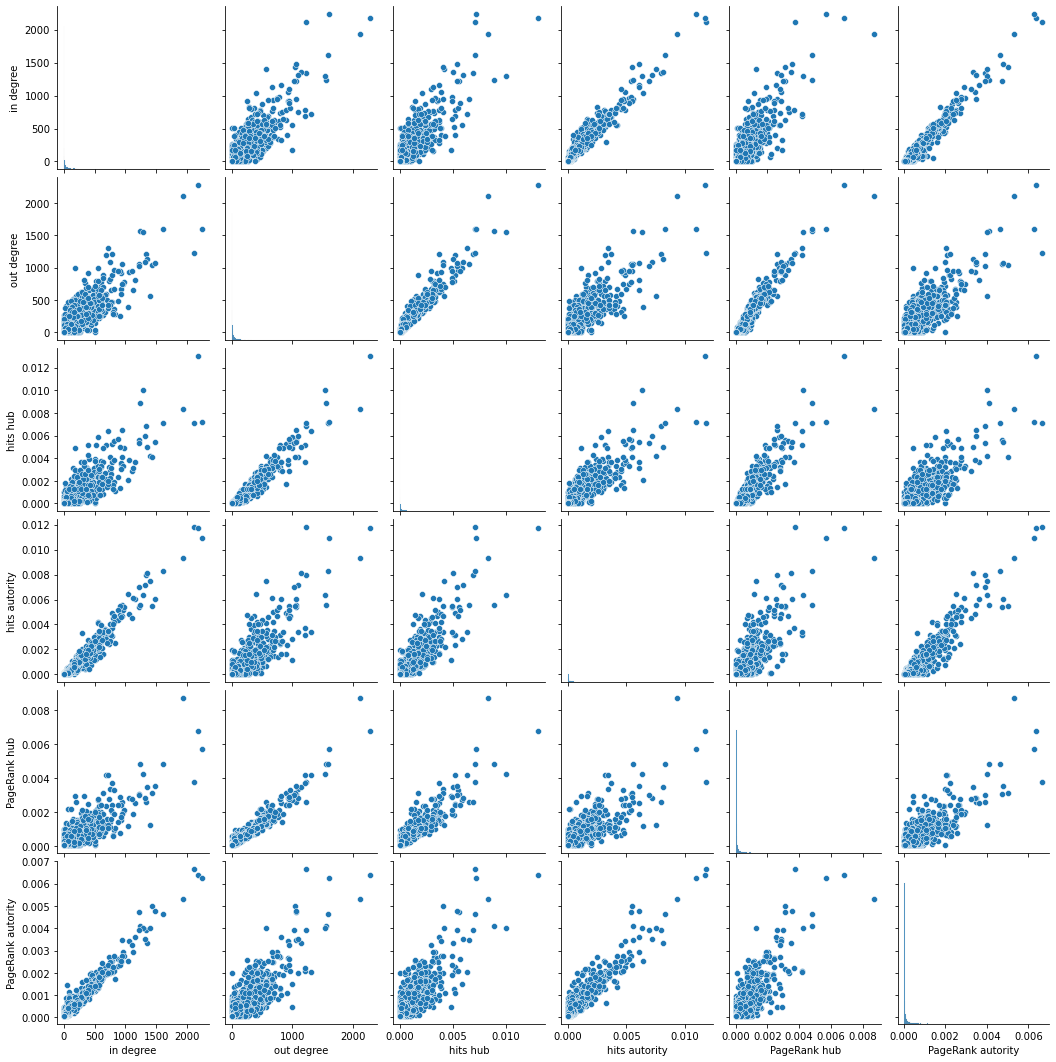

In [18]:
df = ns.pagerank_alg(adj_matrix_crs, nodes_df, score_df=scores, print_graph=True)
scores = pd.merge(scores, df, on='Nodes')

ns.display_top_n(scores, 10, 'PageRank hub')
ns.display_top_n(scores, 10, 'PageRank autority')
# ci vuole troppo a farlo
sns.pairplot(scores[['in degree', 'out degree',  'hits hub',
       'hits autority', 'PageRank hub', 'PageRank autority']])
plt.show()
# from IPython.display import Image
# Image('pairplot_score.png',)

### Assortativity

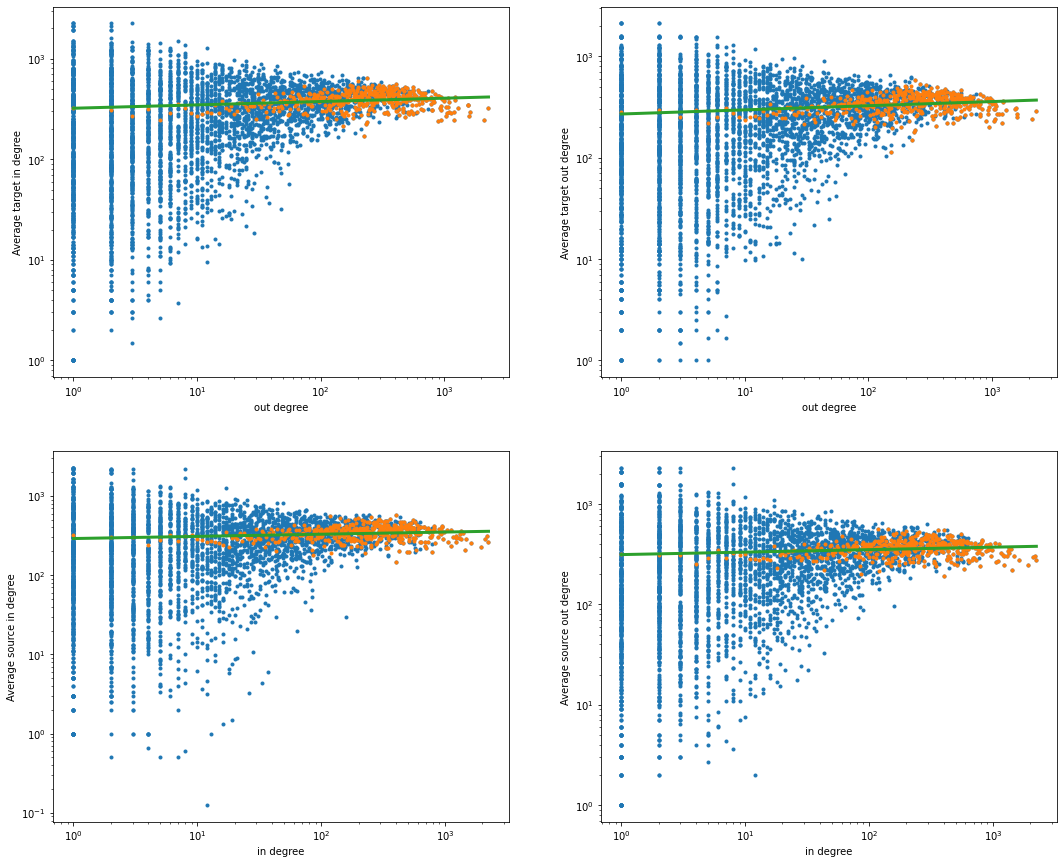

(0.03327460057579345,
 0.04089803647979331,
 0.02728498860993892,
 0.024645650714904713)

In [19]:
edges = mobility_df.copy()
ns.assortativity_calc(edges, adj_matrix_crs, nodes_df, True)